In [20]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import blas, solvers
import pandas as pd
import cvxopt
import math as m
from math import log10, sqrt

# I. Modélisation des données

In [21]:
# Nombre d'actifs :
n_assets = 5

# Nombre d'observations (nbr de jours) : 
n_obs = 1260 # 5 ans, 1 année = (environ) 252 jours.

# On génère les rendements journaliers de nos 5 actifs : on choisit de les simuler à l'aide 
# d'une loi normale centrée réduite, en effet les rendements fictifs ainsi obtenus sont proches des résultats empiriques 
# (cours des actions).
# On ajoute des tendances décidées de manière aléatoire (de même, les durées de ces tendances sont décidées de manière 
# aléatoire pour chaque actif) : 
def  Init_rendement(temps1, temps2, moymin, moymax, n_assets = 5, n_obs = 1260):
    return_vec = np.random.randn(n_assets, n_obs) 
    for p in range(n_assets): 
        cpt = 0 
        while cpt < n_obs : 
            duree_tendance = np.random.randint(temps1,temps2+1)
            tendance = np.random.uniform(moymin, moymax)
            return_vec[p,cpt:duree_tendance+cpt] = (return_vec[p,cpt:duree_tendance+cpt] + tendance)/30
            cpt += duree_tendance
    return(return_vec[:,:n_obs])

return_vec = Init_rendement(159,250,-0.05,0.05)
# print(return_vec)


# Le test vérifie la taille du tableau renvoyé et que les rendements sont compris entre -1 et 1.  

def testunitaire1():
  if Init_rendement(40,200,-0.005,0.01).shape != (5,1260):
    return False
  else : 
    for i in range (5):
      for j in range(1260):
        m = Init_rendement(40, 200, -0.005, 0.01)[i][j]
        if (m < -1) or (m > 1): 
          return False
  return True 

testunitaire1()

True

In [22]:
# Modélisation des prix des actifs : 

def prix_actif(return_vec, n_assets = 5, n_obs = 1260, prix_init = False):
    
    return_vec_1 = pd.DataFrame(return_vec).T
    prix = pd.DataFrame(columns = ['Action' + str(i) for i in range(1,n_assets+1)])
    
    if prix_init == False : 
        prix.loc[0] = [(i+1) * 50 for i in range(n_assets)] # Prix initiaux des 5 actions : (totalement arbitraires) 50, 100, 150, 200, 250
    else:
        prix.loc[0] = prix_init # Prix initiaux décidés par l'utilisateur. 
    prix = prix.astype(np.float64)

    return_vec_1.columns = ['Action' + str(j) for j in range(1,n_assets+1)]
    for i in range(0,n_obs):
        prix.loc[i+1] = prix.iloc[i,:] + prix.iloc[i,:]*return_vec_1.iloc[i,:]
    # prix.plot(figsize = (15,7))
    
    return(prix) 

# prix_actif(Init_rendement(159,250,-0.05,0.05))

# II. Méthode de Markowitz et résolution du problème d'optimisation quadratique

In [23]:
# Le modèle de Markowitz permet, à partir d’une série de portefeuilles, de répondre à la question : 
# Comment minimiser mon risque, pour un niveau de rendement minimum souhaité.

# Fonction permettant de générer des poids de manière aléatoire, dont la somme vaut 1. 
# (tous positifs, on ne peut pas vendre à découvert)
def poids_aleatoire(n):
    
    k = np.random.rand(n)
    return k / sum(k)

# Fonction revoyant la variance moyenne et le rendement moyen d'un portefeuille composé de nos 5 actifs. 
def port_aleatoire(returns):    

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(poids_aleatoire(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T # rendement moyen du portefeuille. 
    sigma = np.sqrt(w * C * w.T) # risque moyen du portefeuille.
    
    return mu, sigma

# Fonction générant des portefeuilles aléatoires, définis par leur variance et rendement moyen : 
def generer_port(returnbis, n_portfolios=500):
    
    means, stds = np.column_stack([port_aleatoire(returnbis) for _ in range(n_portfolios)])
    
    return means, stds

# On représente le nuage de points obtenu (pour chaque portefeuille le couple (means, stds)). 
def plot_port(returnbis, n_portfolios=500):
    means, stds = generer_port(returnbis,n_portfolios)
    # fig = plt.figure()
    # plt.plot(stds, means, 'o', markersize=5)
    # plt.title("Représentation graphique des portefeuilles du marché")
    # plt.ylabel('Rendement espéré')
    # plt.xlabel('Volatilité')
    return(means)


means = plot_port(Init_rendement(159,250,-0.05,0.05), n_portfolios=500)

# Le test vérifie qu'on a la moyenne sur les 500 portefeuilles et que ces 
# moyennes sont comprises entre -1 et 1 

def testunitaire2():
  if len(means) != 500:
    return False
  else : 
    for i in range (500):
      m = means[i]
      if (m < -1) or (m > 1): 
        return False
  return True 
testunitaire2()

True

In [24]:
# Résolution du problème d'optimisation : 
# Objectif : minimiser le risque (càd la variance moyenne) du portefeuille d'actifs 
# sous contrainte d'un rendement moyen minimum. 
# Il s'agit d'un problème d'optimisation quadratique : on utilise le package cvxopt pour le résoudre : 
def cvxopt_qp_solver(r, r_e, cov):
    n = len(r)
    r = cvxopt.matrix(r)
    P = cvxopt.matrix(2.0 * np.array(cov))
    q = cvxopt.matrix(np.zeros((n, 1)))
    G = cvxopt.matrix(np.concatenate((-np.transpose(r), -np.identity(n)), 0))
    h = cvxopt.matrix(np.concatenate((-np.ones((1,1)) * r_e, np.zeros((n,1))), 0))
    A = cvxopt.matrix(1.0, (1, n))
    b = cvxopt.matrix(1.0)    
    return cvxopt.solvers.qp(P, q, G, h, A, b)

# III. Réalisation de backtests pour trouver le pas optimal  de réoptimisation du portefeuille (de réévaluation des poids optimaux)

In [25]:
# Objectif du backtest : trouver la durée optimale pour modifier les poids du portefeuille : 
# Générer les durées à tester : 15-30-45-60-...-180. 

duree_test = np.array(range(15,181,15))

# Fonction pour réaliser un backtest : trouver le pas optimal pour une série financière donnée par l'utilisateur 
# ou générée de manière aléatoire. 

def backtesting(duree_test, n_assets, n_obs, dataset = False, data = 0, prix_init = False):
    
    if dataset != True : 
        # Création des données : choix des tendances, ... 
        t1 = np.random.randint(10,20)
        t2 = np.random.randint(t1,t1+10)
        tt1 = np.random.uniform(-0.005,0.005)
        tt2 = np.random.uniform(-0.005,0.005)
        return_vec = Init_rendement(t1,t2,min(tt1,tt2),max(tt1,tt2))
    else : 
        return_vec = data # Données fournies par l'utilisateur. 
            
    # Choix du rendement moyen minimum souhaité : 3ème quartile, utilisation de la théorie de Markowitz. 
    Q3 = round(np.percentile(plot_port(return_vec), 75),5)
    
    # Calcul des prix des actifs : 
    prix = prix_actif(return_vec, n_assets, n_obs, prix_init)
    return_vec_1 = pd.DataFrame(return_vec).T
   
    # On cherche les poids optimaux en optimisant sur :
    # Ex : pour le 1er pas (i.e. 15) : on optimise sur 0-14, 15-29, 30-44, ...
    resultat = np.zeros(len(duree_test))
    
    for j in range(len(duree_test)):
        w=1000 # Richesse initiale de l'agent. 
        poids = pd.DataFrame(columns = ['Poids' + str(i) for i in range(1,n_assets+1)])

        for i in range(0,n_obs,duree_test[j]):
            r = return_vec_1.iloc[i:np.minimum(i+duree_test[j],n_obs)].mean().values # Rendement espéré.
            r_e = Q3  # Rendement minimum souhaité. 
            cov = return_vec_1.iloc[i:np.minimum(i+duree_test[j],n_obs)].cov() # matrice de covariance.
            
            # Résolution du problème d'optimisation sous contrainte : on réduit la précision, des solutions approchées conviennent.
            solvers.options['feastol'] = 1e-1
            solvers.options['abstol'] = 1e-1
            solvers.options['reltol'] = 1e-1
            solvers.options['show_progress'] = False
            sol = cvxopt_qp_solver(r, r_e, cov)
            poids.loc[i]= sol['x']
        
        
        # Evaluation de la richesse finale de l'agent à la fin de la stratégie : journée n_obs[-1]. 
        argent3 = pd.DataFrame(columns = ['Argent'])
        argent3.loc[0] = w
        argent3 = argent3.astype(np.float64)
        for i in range(0,n_obs,duree_test[j]):
            w = w*poids.loc[i].values/prix.iloc[i].values
            w = (w*prix.iloc[np.minimum(i+duree_test[j]-1,n_obs-1)]).sum()
            argent3.loc[np.minimum(i+duree_test[j],n_obs-1)] = w
        # print(argent3)

        resultat[j] = argent3.iloc[-1] # Richesse finale de l'agent pour le pas j.  

    return(resultat)

backtesting(duree_test, 5, 1260)

array([6848.4246479 , 3712.17542842, 2245.40513565, 1773.83148066,
       1432.66196198,  982.31838212,  916.97813218, 1090.70064181,
        748.16516402,  771.74204544,  775.61966094,  795.02480526])

In [26]:
# Quel est le meilleur pas ? 

# On fait tourner un grand nombre de fois la fonction backtesting en utilisant différentes séries financières. 
# On choisit de le faire 10 fois dans le but de trouver le pas qui a permis de réaliser le plus de "bénéfices" en moyenne. 
# On réalise un classement à chaque étape : 

def trouver_pas_opt(nbr_simul, duree_test, testunit): 
    n = len(duree_test)
    result = np.zeros(n*nbr_simul).reshape((nbr_simul,n))
    for i in range(nbr_simul):
        indice_classe = np.argsort(backtesting(duree_test,5, 1260),axis=None)
        for j in range(n):
            result[i,indice_classe[j]] = j 
    result_condense = np.sum(result, axis=0)
    result_condense1 = pd.DataFrame(result_condense, index = ["Pas opt = " + str(i) for i in duree_test], columns = ["Score obtenu"])
    if testunit == False :
        print("Resultat pour chaque pas (le meilleur pas est celui avec le plus grand score) :", "\n", "\n", result_condense1, "\n", "\n", "Le pas optimal est : ", duree_test[np.argmax(result_condense)])
    else : 
        return (duree_test[np.argmax(result_condense)]) #On renvoie uniquement le pas optimal. 


print(trouver_pas_opt(10, duree_test, False))

# L'algorithme met un peu de temps (environ 40 secondes).
# Le résultat est 15 la plupart du temps. C'est le pas "optimal" d'après ces backtests. 

# Test unitaire : permet de vérifier qu'au moins une fois sur trois on obtient le pas voulu.
# Ce test pose problème par sa complexité (à cause de la complexité de trouver_pas_opt). 

def testunitaire3():
  for i in range (3):
    m = trouver_pas_opt(10, duree_test, True)
    if m == 15:
      return True
  return False 

#testunitaire3()

Resultat pour chaque pas (le meilleur pas est celui avec le plus grand score) : 
 
                Score obtenu
Pas opt = 15          110.0
Pas opt = 30           97.0
Pas opt = 45           83.0
Pas opt = 60           80.0
Pas opt = 75           58.0
Pas opt = 90           45.0
Pas opt = 105          45.0
Pas opt = 120          45.0
Pas opt = 135          34.0
Pas opt = 150          33.0
Pas opt = 165          15.0
Pas opt = 180          15.0 
 
 Le pas optimal est :  15
None


# IV. Extension aux données réelles

In [27]:
# Importation des données réelles : on récupère les prix des stocks de toutes les companies du SPX500
# sur 5 ans (entre 2013.02.08 et 2018.02.07)

import pandas as pd
stocks_df = pd.read_csv('all_stocks_5yr.csv',index_col=0,parse_dates=True)
unique_stocks_names = stocks_df.Name.unique() # on récupère les noms de tous les stocks

stocks = unique_stocks_names
daily_returns = pd.DataFrame() 
for n in range(len(stocks)):
    stock_df =  stocks_df.loc[stocks_df.Name==stocks[n],:] #on sélectionne toutes les lignes qui renvoient au stock n
    stock_daily_return = stock_df["close"].pct_change() # on calcule les rendements quotidiens de ce stock n
    daily_returns[stocks[n]] = stock_daily_return 
    
daily_returns = daily_returns.drop(daily_returns.index[0]) # on enlève la première ligne
daily_returns = daily_returns.dropna(axis=1) #on enlève tous les actions qui possèdent une valeur NaN

daily_returns.head() # on obtient un dataframe de rendements de taille 1258*470 (1258 jours et 470 actifs)

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-11,-0.019661,0.010422,-0.006464,-0.011034,-0.002772,-0.004359,-0.003274,-0.012270,0.008315,0.001985,...,-0.001333,0.002479,-0.003724,-0.000700,0.003769,0.013658,-0.011485,-0.002637,0.002900,0.006354
2013-02-12,-0.013140,-0.025067,0.002679,-0.011994,0.004277,0.001168,0.004106,0.006470,0.004123,0.017503,...,0.003203,0.003532,0.002039,0.000700,-0.003755,0.017844,0.003098,-0.002776,0.011565,0.014432
2013-02-13,0.027330,-0.001903,0.004707,-0.004235,-0.006814,0.004665,0.002590,-0.002057,-0.000216,0.011360,...,0.005854,0.000352,0.002374,0.004899,0.005025,0.011091,-0.005251,0.007423,0.010208,-0.005631
2013-02-14,-0.045703,-0.000899,-0.001646,0.036859,0.002787,0.006965,-0.005846,-0.005153,0.006053,0.007702,...,0.016931,-0.007037,-0.001692,-0.003946,0.003750,0.007431,-0.008073,0.004474,-0.004446,-0.008346
2013-02-15,0.036455,-0.013780,0.002029,0.027618,-0.003635,0.010951,0.014085,0.000648,-0.007843,0.037261,...,-0.008325,0.015946,-0.001808,-0.002564,-0.007472,-0.006674,0.001565,-0.005764,-0.011774,0.021341




[[0.23532022]
 [0.1960469 ]
 [0.20028745]
 [0.18070565]
 [0.18763979]] 

1.0 

Volatilité (x_opt) : 0.010318681708180833


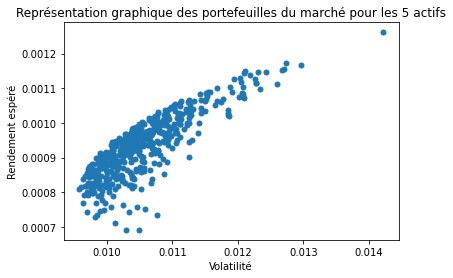

In [28]:
# Modèle de Markowitz 

# On s'intéresse aux 5 actifs suivants : "AMZN","GOOGL","MTD","AZO","BLK"
daily_returns.index = range(1258)
df2 = daily_returns[["AMZN","GOOGL","MTD","AZO","BLK"]].T.values
means, stds = generer_port(df2,500)
fig = plt.figure()
plt.plot(stds, means, 'o', markersize=5)
plt.title("Représentation graphique des portefeuilles du marché pour les 5 actifs")
plt.ylabel('Rendement espéré')
plt.xlabel('Volatilité')

# Retourne le portefeuille optimal pour les 5 actifs considérés

means = plot_port(df2)
r = (pd.DataFrame(df2).T).mean().values # Rendement espéré : 3e quartile
r_e = round(np.percentile(means, 75),5)  # Rendement minimum
cov = np.cov(df2) # Matrice de covariance

solvers.options['feastol'] = 1e-2
solvers.options['abstol'] = 1e-2
solvers.options['reltol'] = 1e-2
solvers.options['show_progress'] = False
sol = cvxopt_qp_solver(r, r_e, cov)
print("\n")
x_opt = np.array(sol['x'])
print(x_opt,"\n") # Affichage des poids.
print(x_opt.sum(),"\n") # On vérifie que la somme des poids vaut 1. 
print("Volatilité (x_opt) :", np.sqrt(sol["primal objective"])) # Donne le risque minimum. 

 

On observe bien que la meilleure stratégie est le pas de 15.


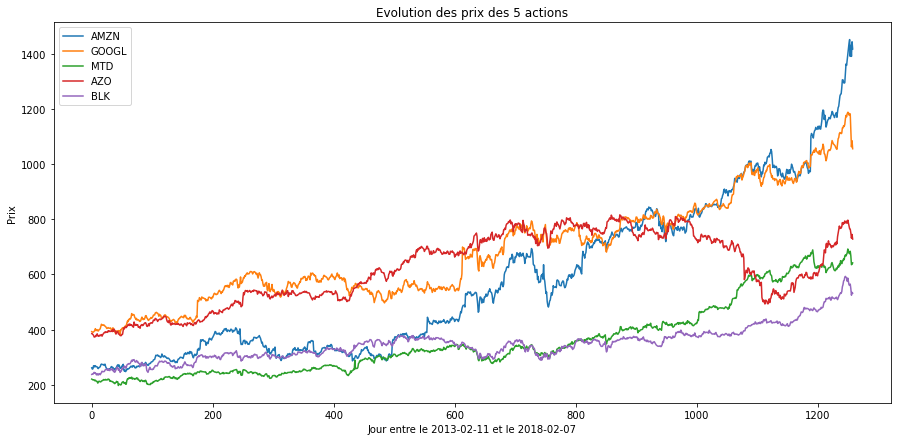

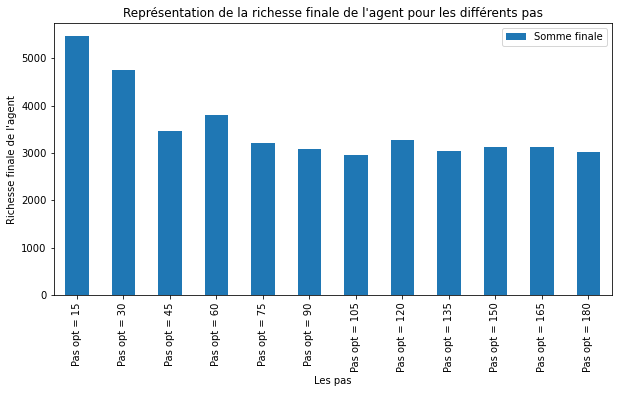

In [29]:
# Backtest avec les données réelles : 

resultat = pd.DataFrame(backtesting(duree_test, df2.shape[0], df2.shape[1], True, df2, [261.95,393.0777,221.15,385.89,238.16]), index = ["Pas opt = " + str(i) for i in duree_test], columns = ["Somme finale"])

prix_actif(df2, n_assets = df2.shape[0], n_obs = df2.shape[1], prix_init = [261.95,393.0777,221.15,385.89,238.16]).plot(figsize = (15,7))
plt.legend(["AMZN","GOOGL","MTD","AZO","BLK"])
plt.title("Evolution des prix des 5 actions")
plt.ylabel("Prix")
plt.xlabel('Jour entre le 2013-02-11 et le 2018-02-07')

resultat.plot(figsize = (10,5),kind = 'bar')
plt.title("Représentation de la richesse finale de l'agent pour les différents pas")
plt.ylabel("Richesse finale de l'agent")
plt.xlabel('Les pas')
print("On observe bien que la meilleure stratégie est le pas de 15.")

# V. Estimation de la matrice de covariance 

In [30]:
# Matrice de covariance empirique

def sample_cov_matrix(data):
    T = len(data)
    mean_vector = np.vstack(data.mean().to_numpy())
    cov = 0
    for i in range(T):
        vector = np.vstack(data.iloc[i,:].to_numpy())
        cov += np.dot(vector - mean_vector, np.transpose(vector - mean_vector))
    cov /= T-1
    return cov

# Matrice de corrélation déterminée à partir de la matrice de covariance

def corr_matrix(cov):
    N = len(cov)
    corr = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            corr[i,j] = cov[i,j]/sqrt(cov[i,i]*cov[j,j])
    return corr

### Shrinkage linéaire
On écrit la matrice de covariance (sample covariance matrix) dans sa décomposition en valeurs propres : 
    $$ \Sigma = \sum_{i=1}^N \lambda_i u_i u_i^T$$ où $\lambda_i$ est la i-ème valeur propre de $\Sigma$ et $u_i$ son vecteur propre associé.
    La matrice réduite (linear shrinkage estimator) est donnée par : 
    $$ \hat{\Sigma} = \sum_{i=1}^N \gamma_i u_i u_i^T$$ où $\gamma_i = \rho \lambda_i + (1-\rho)\bar{\lambda}$ où $\bar{\lambda}$ est la moyenne des valeurs propres de $\Sigma$ et $0 < \rho < 1$, un paramètre qui détermine le degré de réduction. D'où :
    $$ \hat{\Sigma} = (1-\rho) \Sigma + \rho \bar{\lambda} I_N$$


In [31]:
def shrink_cov(data, rho):
    cov = sample_cov_matrix(data)
    N = cov.shape[0]
    m = np.mean(np.linalg.eigh(cov)[0])
    target = np.identity(N)*m
    sigma_shrink = (1-rho)*cov + rho*target
    return sigma_shrink


### Random Matrix Theory 0 (RMT-0)

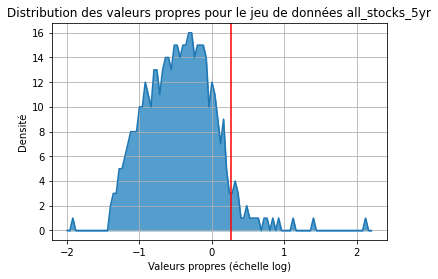

In [32]:
#Répartition des valeurs propres (en log) de la matrice de covariance : 
def plot_eigenvalues_distribution(data):
    cov = sample_cov_matrix(data)
    corr = corr_matrix(cov)
    eigenvalues = np.linalg.eigh(corr)[0]
    
    # Echelle en log (log_scale)
    log_eigenvalues = [log10(l) for l in eigenvalues]
    min_scale = -2
    max_scale = 2.2
    pas = 0.04
    N = int((max_scale-min_scale)/pas + 1)
    
    log_scale = [min_scale]
    for k in range(1,N):
        log_scale.append(min_scale+k*pas)
    
    nb_of_eigenvalues = [0]*N
    for k in range(N):
        c=0
        for l in log_eigenvalues:
            if l>-2+k*pas and l<=-2+(k+1)*pas:
                c+=1
        nb_of_eigenvalues[k]=c
        
    Q = data.shape[0]/data.shape[1] 
    lambda_1 = np.max(eigenvalues)
    lambda_max = (1-(lambda_1/data.shape[1]))*(1+1/Q+2*np.sqrt(1/Q))
    
    plt.plot(log_scale,nb_of_eigenvalues)
    plt.fill_between(log_scale,nb_of_eigenvalues, color='#539ecd')
    plt.axvline(x=log10(lambda_max),color='red')
    plt.title('Distribution des valeurs propres pour le jeu de données all_stocks_5yr')
    plt.xlabel('Valeurs propres (échelle log)')
    plt.ylabel('Densité')
    plt.grid()
    plt.show()
    
plot_eigenvalues_distribution(daily_returns)

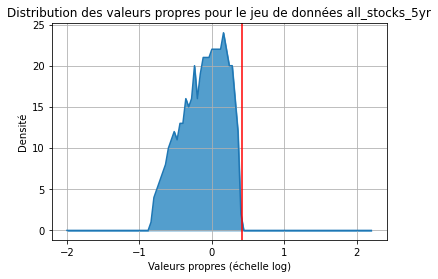

In [33]:
matrice_aléatoire = pd.DataFrame(np.random.normal(0,1,size=(1258,470)))
plt.title('Distribution des valeurs propres pour une matrice aléatoire de taille 1258*470')
plot_eigenvalues_distribution(matrice_aléatoire)

In [34]:
def RMT_0(data):
    
    Q = data.shape[0]/data.shape[1] #ratio fixé = T/N
    cov = sample_cov_matrix(data)
    corr = corr_matrix(cov)
    corr_eigenvalues = np.linalg.eigh(corr)[0]
    
    lambda_1 = np.max(corr_eigenvalues)
    lambda_max = (1-(lambda_1/data.shape[1]))*(1+1/Q+2*np.sqrt(1/Q))
    
    # Diagonalisation de la matrice de corrélation
    P = np.linalg.eigh(corr)[1] # matrice de passage
    D = np.diag(np.linalg.eigh(corr)[0]) # matrice diagonale de valeurs propres
    
    # On remplace les valeurs propres (sur la diagonale de D) inférieures ou égales à lambda_max par 0 
    D2 = D
    for i in range(len(D)):
        if D[i][i] <= lambda_max:
            D2[i][i] = 0  
    H_RMT = P@D2@(P.T)
    
    # Matrice de corrélation filtrée
    C_RMT = H_RMT
    for i in range(len(H_RMT)):
        C_RMT[i][i] = 1
        
    # Matrice de covariance filtrée
    n = len(C_RMT)
    S_RMT = np.zeros((n,n))
    for i in range(len(C_RMT)):
        for j in range(len(C_RMT)):
            S_RMT[i][j] = C_RMT[i][j]*(m.sqrt(cov[i,i]*cov[j,j]))
    return S_RMT
